# DL1 Assignment2 - Q1.1 draft code

This is a small help from us to save you some coding. This notebook is **not** graded, you are free to edit it.

Further advise:
1. Start with File/Save a copy in Drive
2. Set GPU usage under Runtime/Change runtime type/Hardware accelerator.

In [1]:
!pip install timm

In [2]:
import torch
from torch import nn
import timm
from torchvision import models
from matplotlib import pyplot as plt
from typing import Callable

%matplotlib inline

In [3]:
def vit_s_8():
    """ViT-S/8 is not a default torchvision model, so we provide it by timm"""
    # Accuracy approximation comes from
    # https://openreview.net/pdf?id=LtKcMgGOeLt
    # and DINO
    # https://arxiv.org/abs/2104.14294
    return timm.create_model('vit_small_patch8_224')

# Model definitions
# Optional Q: These are uncalled functions. What do you think would happen
# if we called all of them once? Why didn't we do that?
model_defs = [
    vit_s_8,
    models.vit_b_32,
    models.vgg11,
    models.vgg11_bn,
    models.resnet18,
    models.densenet121,
    models.mobilenet_v3_small,
]

# Accuracies per model
model_accs = {
    'vit_s_8': 80., # Approximated
    'vit_b_32' : 75.912,
    'vgg11' : 69.02,
    'vgg11_bn' : 70.37,
    'resnet18' : 69.758,
    'densenet121' : 74.434,
    'mobilenet_v3_small' : 67.668,
}


def measure_runtime_per_forward(model:nn.Module, no_grad:bool, batch_size:int=8):
    """Measures the time for a single pass in milliseconds"""

    # Generate fake RGB input (224x224)
    #######################
    # PUT YOUR CODE HERE  #
    #######################
    inp = torch.rand(batch_size, 3, 224, 224)
    #######################
    # END OF YOUR CODE    #
    #######################

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()

    # Run the model
    #######################
    # PUT YOUR CODE HERE  #
    #######################
    model.eval() #Set the model to evaluation mode

    if no_grad:
      with torch.no_grad():
          # Run the images through the model
          outputs = model(inp.cuda())
    else:
      outputs = model(inp.cuda())
    #######################
    # END OF YOUR CODE    #
    #######################

    end.record()
    torch.cuda.synchronize()
    final_vram = torch.cuda.memory_allocated()

    return start.elapsed_time(end), final_vram


def evaluate_model(model_def:Callable, no_grad:bool, batch_size:int=8):

    # Retreive initial memory allocation
    initial_vram = torch.cuda.memory_allocated()

    # Define model
    model = model_def().cuda().eval()
    # Access name as: model.__name__

    # Parameters that need to be filled

    #######################
    # PUT YOUR CODE HERE  #
    #######################
    # Step 1: Calculate the number of **trainable** parameters
    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    n = 10
    time_i, vram_i = 0, 0

    # Step 2: Warm up with a few passes
    for i in range(n):
      # Step 3: Run N forward passes and save the runtime +
      #         the vram allocated by the model
      times, vrams = measure_runtime_per_forward(model, no_grad, batch_size)
      time_i += times
      vram_i += vrams

    # Step 4: Take the mean, preferably with dropping possible outliers
    mean_time = time_i / batch_size / n
    mean_vram = (vram_i - initial_vram) / batch_size / n
    #######################
    # END OF YOUR CODE    #
    #######################

    # Clean up space for the model
    del model
    torch.cuda.empty_cache()

    return mean_time, mean_vram, n_params



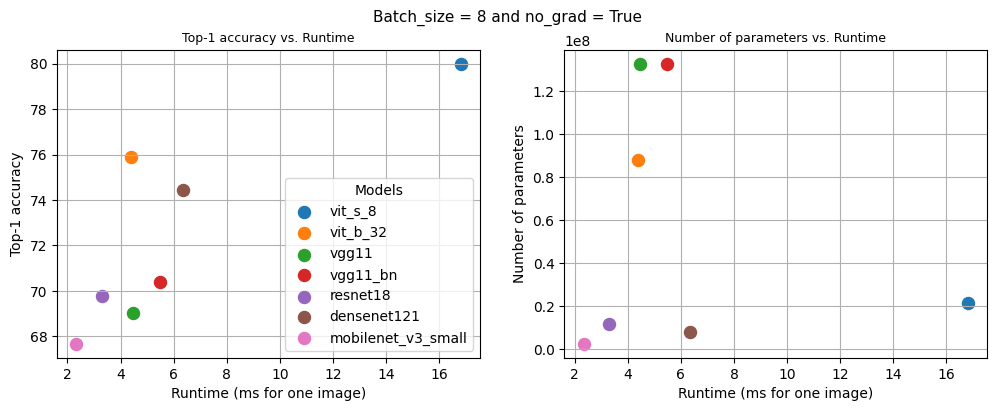

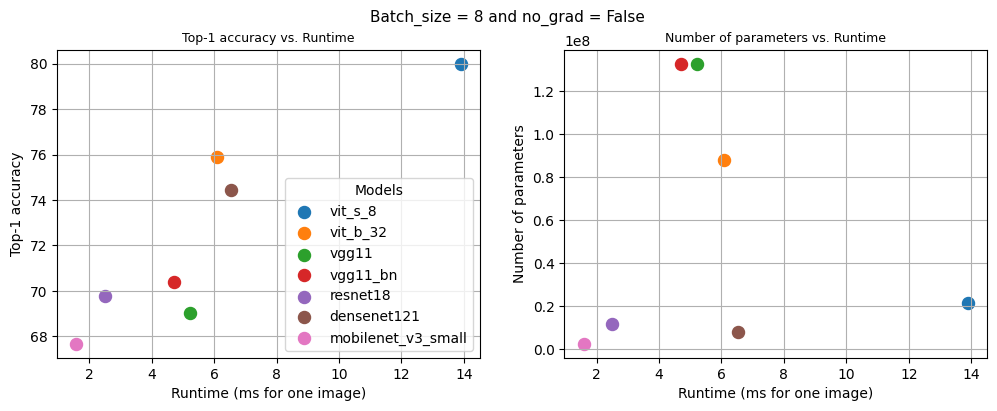

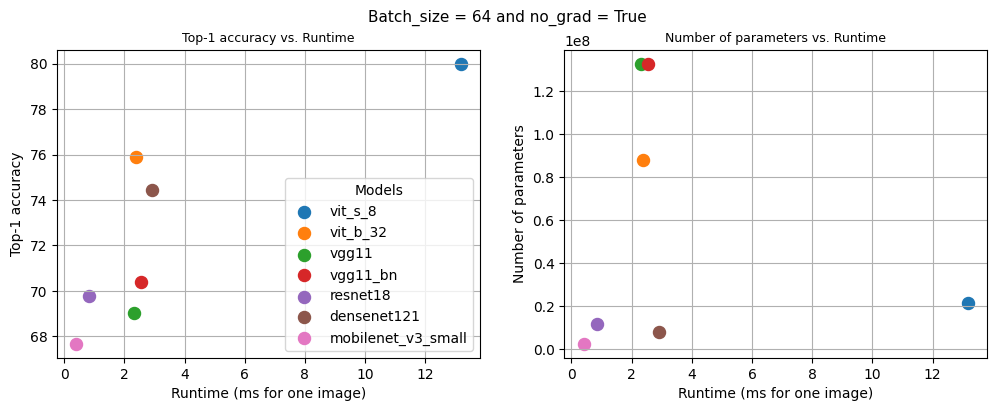

In [4]:
#######################
# PUT YOUR CODE HERE  #
#######################
def plot_graphs(no_grad:bool, batch_size:int = 8):
  fig, ax = plt.subplots(1, 2, figsize = (12, 4))
  size = 75
  times, vrams, n_params = [], [], []

  for model_def in model_defs:
      name = model_def.__name__
      time, vram, n_param = evaluate_model(model_def, no_grad=no_grad, batch_size=batch_size)
      times.append(time)
      vrams.append(vram*10**(-6))
      n_params.append(n_param)
      ax[0].scatter(time, model_accs[name], s=size, label = name)
      ax[1].scatter(time, n_param, s=size, label = name)

  ax[0].set_ylabel('Top-1 accuracy')
  ax[0].set_xlabel('Runtime (ms for one image)')
  ax[0].grid(True)
  ax[0].set_title('Top-1 accuracy vs. Runtime', fontsize=9)
  legend = ax[0].legend(title = 'Models')
  ax[1].set_ylabel('Number of parameters')
  ax[1].set_xlabel('Runtime (ms for one image)')
  ax[1].set_title('Number of parameters vs. Runtime', fontsize=9)
  ax[1].grid(True)
  fig.suptitle('Batch_size = ' + str(batch_size) + ' and no_grad = ' + str(no_grad), fontsize=11)
  plt.show()

  return times, vrams, n_params

time, vram, _ = plot_graphs(no_grad = True)

# With no_grad = False and batch_size = 8
time_grad, vram_grad, _ = plot_graphs(no_grad = False)



# With no_grad = True and batch_size = 64
time_64_grad, vram_grad, _ = plot_graphs(no_grad = True, batch_size = 64)
#######################
# END OF YOUR CODE    #
#######################

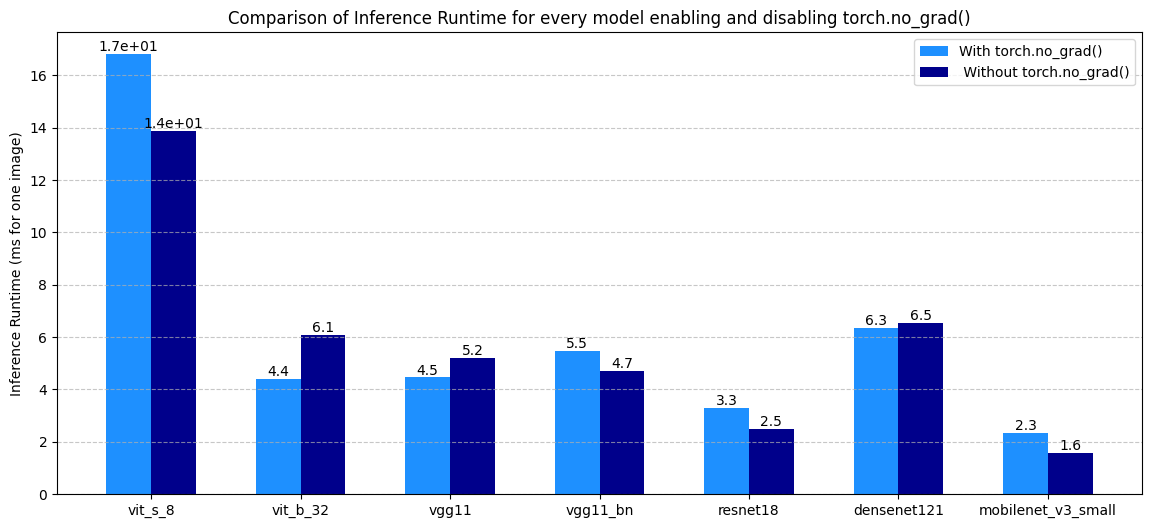

In [10]:
import numpy as np


categories = []
for model_def in model_defs:
    name = model_def.__name__
    categories.append(name)

vals = time
values_stemmed = time_grad

bw = .3
colors = ['dodgerblue', 'darkblue']

fig, ax = plt.subplots(figsize=(14, 6))
bars1 = ax.bar(np.arange(len(categories)), vals, bw, label='With torch.no_grad()', color = colors[0])
bars2 = ax.bar(np.arange(len(categories)) + bw, values_stemmed, bw, label=' Without torch.no_grad()', color = colors[1])

for bars, vals in zip([bars1, bars2], [vals, values_stemmed]):
    for bar, value in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), "{:.2}".format(value), ha='center', va='bottom')


plt.ylabel('Inference Runtime (ms for one image)')
plt.title('Comparison of Inference Runtime for every model enabling and disabling torch.no_grad()')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend()
ax.set_xticks(np.arange(len(categories)) + bw / 2)
ax.set_xticklabels(categories)
plt.show()

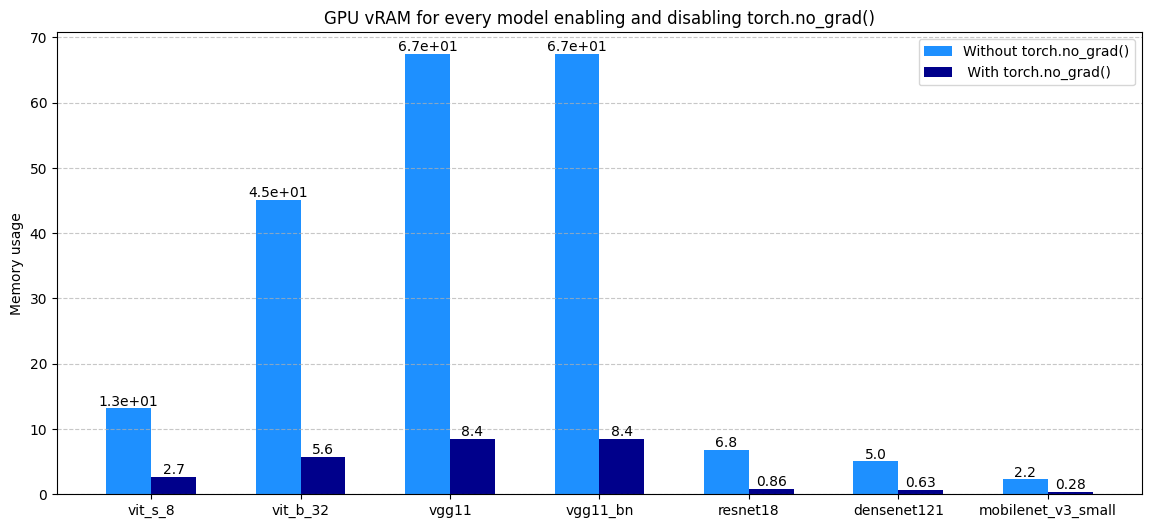

In [9]:
import numpy as np


categories = []
for model_def in model_defs:
    name = model_def.__name__
    categories.append(name)

vals = vram
values_stemmed = vram_grad

bw = .3
colors = ['dodgerblue', 'darkblue']

fig, ax = plt.subplots(figsize=(14, 6))
bars1 = ax.bar(np.arange(len(categories)), vals, bw, label='Without torch.no_grad()', color = colors[0])
bars2 = ax.bar(np.arange(len(categories)) + bw, values_stemmed, bw, label=' With torch.no_grad()', color = colors[1])

for bars, vals in zip([bars1, bars2], [vals, values_stemmed]):
    for bar, value in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), "{:.2}".format(value), ha='center', va='bottom')

# Add labels and title
plt.ylabel('Memory usage')
plt.title('GPU vRAM for every model enabling and disabling torch.no_grad()')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.legend()
ax.set_xticks(np.arange(len(categories)) + bw / 2)
ax.set_xticklabels(categories)
plt.show()